## Heston Model
This notebook uses the model `finmc.models.heston.hestonMC` and shows how to
- create dataset for this model
- use `finmc` calcs to plot asset evolution and implied vol.

In [1]:
import numpy as np
import pandas as pd

from finmc.calc.impliedvol import iv_surface_mc, atmvols_mc
from finmc.models.heston import HestonMC
from finmc.plots.asset import plot_asset
from finmc.plots.impliedvol import plot_iv, plot_atmvols
from finmc.utils.assets import flat_discount, flat_fwds

Create dataset for this model. See [Heston Model Documentation](https://finlib.github.io/finmc/models/heston/) for explanation of model parameters.

In [2]:
asset_name = "SPX"
spot = 2900
rate = 0.02

dataset = {
    "MC": {"PATHS": 100_000, "TIMESTEP": 1 / 250, "SEED": 1},
    "BASE": "USD",
   "ASSETS": {
        "USD": ("ZERO_RATES", np.array([[0.2, 0.05], [0.5, 0.04], [1.0, 0.05]])),
        "SPX": ("FORWARD", np.array([[0.0, 5500], [1.0, 5600]])),
    },
    "HESTON": {
        "ASSET": asset_name,
        "INITIAL_VAR": 0.04,
        "LONG_VAR": 0.07,
        "VOL_OF_VOL": 0.45,
        "MEANREV": 1.5,
        "CORRELATION": 0.5,
    },
}

In [3]:
# create the model
model = HestonMC(dataset)

### Evolution of the asset.

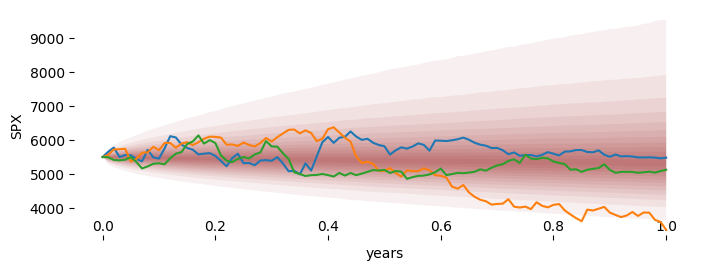

In [4]:
plot_asset(model, asset_name)

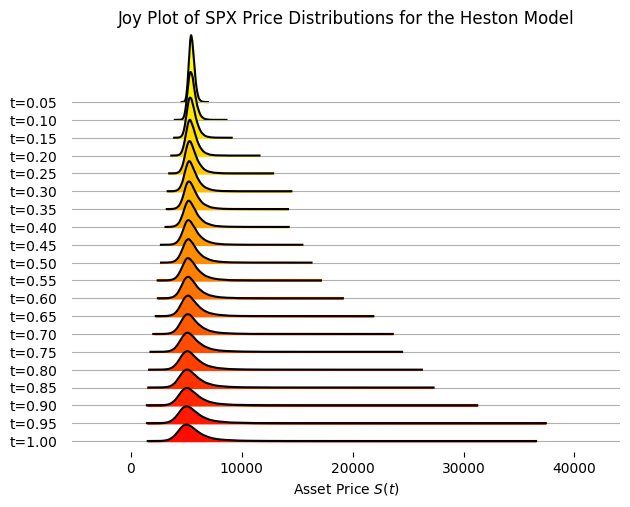

In [5]:
import matplotlib.pyplot as plt
from matplotlib import cm
import joypy
# Step 3: Generate asset paths for joy plot
times = np.linspace(0.05, 1.0, 20)  # Time steps
model.reset()

# Collect asset prices at different time steps
all_prices = []
all_times = []

for t in times:
    model.advance(t)
    prices = model.get_value(asset_name)  # Get asset price at each path
    all_prices.extend(prices)
    all_times.extend([f"t={t:4.2f}"] * len(prices))

# Step 4: Create DataFrame for joypy
samples_df = pd.DataFrame({"values": all_prices, "time": all_times})

# Step 5: Create the Joy Plot
fig, axes = joypy.joyplot(
    samples_df,
    by="time",
    column="values",
    colormap=cm.autumn_r,
    kind="kde",
    range_style="own",
    grid="y",
    tails=1e-2,
)

plt.xlabel("Asset Price $S(t)$")
plt.ylabel("Time Steps $t$")
plt.title(f"Joy Plot of {asset_name} Price Distributions for the Heston Model")
plt.show()

### Plot the Implied Volatility Surface

In [6]:
# Calculate the implied volatility surface
strikes = np.linspace(2000, 3400, 15)
expirations = np.array([1 / 12, 1 / 6, 1 / 4, 1 / 2, 1])
surface = iv_surface_mc(
    strikes,
    expirations,
    asset_name="SPX",
    model=model,
)
# Surface is a 2D numpy array. print as dataframe
pd.DataFrame(surface, columns=strikes, index=expirations)

,2000.0,2100.0,2200.0,2300.0,2400.0,2500.0,2600.0,2700.0,2800.0,2900.0,3000.0,3100.0,3200.0,3300.0,3400.0
0.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.219169,0.216721,0.214414,0.21202,0.209935


Plot now.

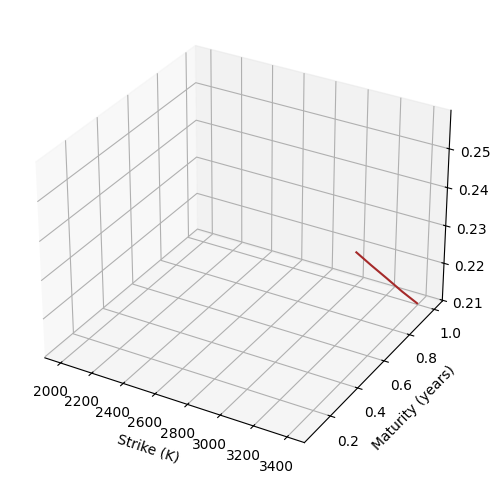

In [7]:
plot_iv(strikes, expirations, surface)

### Plot ATM Volatilities

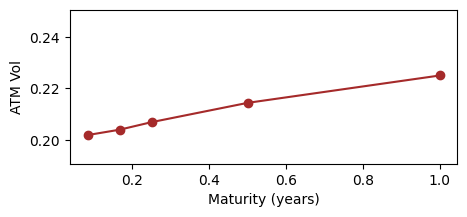

In [8]:
atmvols, fwds = atmvols_mc(
    expirations,
    asset_name="SPX",
    model=model,
)
plot_atmvols(expirations, atmvols)